This is a modified version of the notebook by Triulzi at https://github.com/GiorgioTriulzi/TechnologyPerformanceImprovementEstimates/blob/master/Estimate%20TIR%20for%20new%20domains.ipynb

# Import libraries

In [6]:
import pandas as pd
from pylab import *
import seaborn as sns
sns.set(style="whitegrid")
import gc
import scipy
from scipy.stats.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
pd.set_option('display.max_columns', None)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
alpha=60

# Define functions

In [8]:
# there is a bug with the command to input exogenous observation and obtain the prediction interval
# the solution is described in the following three posts and it uses the function defined here
# description of the bug: https://github.com/statsmodels/statsmodels/issues/987
# solution: https://stackoverflow.com/questions/32593522/return-std-and-confidence-intervals-for-out-of-sample-prediction-in-statsmodels
# jupyter notebook describing solutions: http://nbviewer.jupyter.org/gist/thatneat/10286720
# see also: https://ishaan.xyz/blog/confidence-intervals-vs-prediction-intervals-in-python/

def transform_exog_to_model(fit, exog):
    transform=True
    self=fit

    # The following is lifted straight from statsmodels.base.model.Results.predict()
    if transform and hasattr(self.model, 'formula') and exog is not None:
        from patsy import dmatrix
        exog = dmatrix(self.model.data.orig_exog.design_info.builder,
                       exog)

    if exog is not None:
        exog = np.asarray(exog)
        if exog.ndim == 1 and (self.model.exog.ndim == 1 or
                               self.model.exog.shape[1] == 1):
            exog = exog[:, None]
        exog = np.atleast_2d(exog)  # needed in count model shape[1]

    # end lifted code
    return exog

# Define import and export paths

In [9]:
import_path ="../databases/"# '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Input/'
export_path ="output/"# '/Users/g.triulzi/Dropbox (MIT)/Paper Predicting K with Patents/Data/Output/'

# Import and manipulate data

### Patent variables for all USPTO patents

In [10]:
# Read file with information on all utility patents granted by the USPTO 
PATENT_INFO = pd.read_csv(import_path+'patent_cpc_str.csv') 
PATENT_INFO.drop_duplicates('patent_id', keep = 'first', inplace=True)

PATENT_INFO.rename(columns={'patent_id': 'patent_number', 'group_id':'mainclass_id', 'date': 'grant_year'}, inplace=True)
PATENT_INFO['mainclass_id'] = PATENT_INFO['mainclass_id'].astype(str)
PATENT_INFO['patent_number'] = PATENT_INFO['patent_number'].astype(int)

In [11]:
PATENT_INFO

,number,grant_year,abstract,title,patent_number,mainclass_id,subgroup_id
0,10000000,2018,A frequency modulated (coherent) laser detecti...,Coherent LADAR using intra-pixel quadrature de...,10000000,G01S,G01S7/4917
1,10000001,2018,The injection molding machine includes a fixed...,Injection molding machine and mold thickness c...,10000001,B29C,B29C2945/76227
2,10000002,2018,The present invention relates to: a method for...,Method for manufacturing polymer film and co-e...,10000002,B32B,B32B2250/00
3,10000003,2018,The invention relates to a method for producin...,Method for producing a container from a thermo...,10000003,B29L,B29L2031/7158
4,10000004,2018,The present invention relates to provides a do...,"Process of obtaining a double-oriented film, c...",10000004,B29K,B29K2023/086
...,...,...,...,...,...,...,...
6724459,9999995,2018,A method for producing a molded article of a f...,Method for producing molded article of fiber-r...,9999995,B29C,B29C43/58
6724460,9999996,2018,A polymer or polymer composite membrane having...,Polymer or polymer composite membrane having t...,9999996,B01D,B01D2323/08
6724461,9999997,2018,A metal-plastic composite and method for produ...,Metal-plastic composite and method for produci...,9999997,B23K,B23K2101/34
6724462,9999998,2018,A glass/resin laminate (A) including glass pla...,Glass-resin laminate and method for producing ...,9999998,B32B,B32B17/10788


### Patent sets for 30 domains

In [12]:
# Read file with list of patents for each domain
PATENT_SET_30_DOMAINS = pd.read_csv(import_path+'/Domains_patent_info_katz.csv') #/Triulzi/Domains_..
PATENT_SET_30_DOMAINS['patent_number'] = PATENT_SET_30_DOMAINS['patent_number'].astype(int)

In [13]:
PATENT_SET_30_DOMAINS

,Unnamed: 0,Domain,patent_number,grant_date,filing_date,filing_year_x,filing_year_month,mainclass_id,cit_received_dec2015,CIT_DEC2015_RANK_PERC_BY_YEAR,CITE3,CITE3_RANK_PERC_BY_YEAR,CITE3_RANK_PERC_BY_YEAR_AND_CLASS,mean_age_cited_patents,mean_age_cited_patents_RANK_PERC_BY_YEAR,IPC4,SPNP_count_2015,SPNP_count_t+2,SPNP_count_t+3,meanSPNPcited_1year_before,SPNP_count_2015_randomized_percentile,SPNP_count_t3_randomized_percentile,meanSPNPcited_1year_before_randomized_percentile,count_citations_made,log_count_citations_made,within_USPCclass_citation_count,within_USPCclass_citation_share,within_IPCclass_citation_count,within_IPCclass_citation_share,within_domain_citation_count,within_domain_citation_share,SPNP_count_2015_RankPerc_by_year,SPNP_count_t+2_RankPerc_by_year,SPNP_count_t3_RankPerc_by_year,meanSPNPcited_1year_before_RankPerc_by_year,log_meanSPNPcited_1y_before,SPNP_count_2015_randomized_zscore,meanSPNPcited_1year_before_randomized_zscore,SPNP_count_t2_randomized_zscore,SPNP_count_t3_randomized_zscore,SPNP_count_t5_randomized_zscore,SPNP_count_t8_randomized_zscore,SPNP_count_2015_randomized_zscore_RPbyYear,SPNP_count_t2_randomized_zscore_RPbyYear,SPNP_count_t3_randomized_zscore_RPbyYear,SPNP_count_t5_randomized_zscore_RPbyYear,SPNP_count_t8_randomized_zscore_RPbyYear,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,bwd_self_cit,share_bwd_self_cit,CITE3_SELF,CITE3_SHARE_SELF,count_citations_made_RANK_PERC_BY_YEAR,CITE3byOthers,CITE3byOthers_RANK_PERC_BY_YEAR,filing_year_y,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI
0,0,AIRCRAFT,15291,NaN,NaN,NaN,NaN,139.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AIRCRAFT,3997131,1976-12-14,1976-04-05,1976.0,1976-04-01,244.0,22.0,0.863661,1.0,0.631864,0.718884,NaN,NaN,B64C,1.727504e+09,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522426,0.554385,0.459180,NaN,NaN,-4.317269,NaN,NaN,-0.377991,-0.814872,-1.208815,0.407571,NaN,0.418361,0.195812,0.105336,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.323998e+12,28.832189,0.0,0.486174,28.832189,0.000000e+00,0.003559
2,2,AIRCRAFT,3999630,1976-12-28,1976-03-26,1976.0,1976-03-01,186.0,19.0,0.827262,1.0,0.631864,0.650000,NaN,NaN,B64D,1.418751e+07,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341138,0.554385,0.459180,NaN,NaN,-4.686275,NaN,-0.185634,-0.427577,-0.129650,-0.670929,0.362832,0.675415,0.345775,0.670810,0.347260,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.362607e+11,26.541153,0.0,0.424335,26.541153,3.552714e-15,0.007102
3,3,AIRCRAFT,3987982,1976-10-26,1976-01-26,1976.0,1976-01-01,244.0,12.0,0.683103,0.0,0.254069,0.278970,NaN,NaN,B64C,3.157999e+04,1.000000e+00,1.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181256,0.208409,0.165383,NaN,NaN,-11.853929,NaN,NaN,NaN,NaN,NaN,0.010772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1976.0,3.317891e+05,12.712255,0.0,0.176351,12.712255,0.000000e+00,0.003559
4,4,AIRCRAFT,3998408,1976-12-21,1976-02-19,1976.0,1976-02-01,244.0,5.0,0.365446,1.0,0.631864,0.718884,NaN,NaN,B64D,3.680717e+10,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663036,0.554385,0.459180,NaN,NaN,-3.486356,NaN,-0.147246,-0.411485,-0.068423,-0.228090,0.516151,0.802189,0.377098,0.692383,0.585292,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,1.047986e+15,34.585647,0.0,0.709152,34.585647,0.000000e+00,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511565,511565,HYBRID_CORN,8674196,2014-03-18,2

### Performance Improvement Rate for 30 domains

In [15]:
# Read file with observed TIRs for each domain
PERFORMANCE_DOMAINS = pd.read_csv(import_path+'Triulzi/PERFORMANCE_DOMAINS_K_Kr2.csv')
PERFORMANCE_DOMAINS['log_K'] = log(PERFORMANCE_DOMAINS['K'])

### Patent sets for new domain(s)

In [16]:

NEW_SPNP_DATA=pd.read_csv( 'output/Katz_centrality_RP'+str(alpha)+'.csv' , dtype={'patent_number': int}) #  'Katz_centrality_light' + str(int(alpha*100)) +'.csv'
NEW_SPNP_DATA=NEW_SPNP_DATA[NEW_SPNP_DATA.filing_year<=2017]

In [17]:
NEW_SPNP_DATA

,Unnamed: 0,patent_number,filing_year,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI,AI_gap,AI_centrality_RPbyYear
0,0,10000000,2015,1.0,6.300655,0.097710,0.166140,0.097710,6.202945,0.162593,0.003547,0.001312
1,1,10000001,2015,1.0,9.669530,0.467708,0.313078,0.467708,9.201822,0.288075,0.025003,0.001312
2,2,10000002,2014,1.0,2.531276,0.000000,0.081330,0.000000,2.531276,0.081330,0.000000,0.000597
3,3,10000003,2013,1.6,9.969787,0.893637,0.339862,1.363641,8.606146,0.265128,0.074734,0.057181
4,4,10000004,2015,1.0,4.936201,0.000000,0.125848,0.000000,4.936201,0.125848,0.000000,0.000658
...,...,...,...,...,...,...,...,...,...,...,...,...
6410586,6410586,9999995,2014,1.0,4.152586,0.000000,0.111057,0.000000,4.152586,0.111057,0.000000,0.000597
6410587,6410587,9999996,2014,1.0,6.326487,0.000000,0.171509,0.000000,6.326487,0.171509,0.000000,0.000597
6410588,6410588,9999997,2016,1.0,11.217350,0.125837,0.379997,0.125837,11.091513,0.372324,0.007674,0.001181
6410589,6410589,9999998,2016,1.0,5.106653,0.000000,0.116838,0.000000,5.106653,0.116838,0.000000,0.000592


In [19]:
PATENT_SET_30_DOMAINS

,Unnamed: 0,Domain,patent_number,grant_date,filing_date,filing_year_x,filing_year_month,mainclass_id,cit_received_dec2015,CIT_DEC2015_RANK_PERC_BY_YEAR,CITE3,CITE3_RANK_PERC_BY_YEAR,CITE3_RANK_PERC_BY_YEAR_AND_CLASS,mean_age_cited_patents,mean_age_cited_patents_RANK_PERC_BY_YEAR,IPC4,SPNP_count_2015,SPNP_count_t+2,SPNP_count_t+3,meanSPNPcited_1year_before,SPNP_count_2015_randomized_percentile,SPNP_count_t3_randomized_percentile,meanSPNPcited_1year_before_randomized_percentile,count_citations_made,log_count_citations_made,within_USPCclass_citation_count,within_USPCclass_citation_share,within_IPCclass_citation_count,within_IPCclass_citation_share,within_domain_citation_count,within_domain_citation_share,SPNP_count_2015_RankPerc_by_year,SPNP_count_t+2_RankPerc_by_year,SPNP_count_t3_RankPerc_by_year,meanSPNPcited_1year_before_RankPerc_by_year,log_meanSPNPcited_1y_before,SPNP_count_2015_randomized_zscore,meanSPNPcited_1year_before_randomized_zscore,SPNP_count_t2_randomized_zscore,SPNP_count_t3_randomized_zscore,SPNP_count_t5_randomized_zscore,SPNP_count_t8_randomized_zscore,SPNP_count_2015_randomized_zscore_RPbyYear,SPNP_count_t2_randomized_zscore_RPbyYear,SPNP_count_t3_randomized_zscore_RPbyYear,SPNP_count_t5_randomized_zscore_RPbyYear,SPNP_count_t8_randomized_zscore_RPbyYear,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,bwd_self_cit,share_bwd_self_cit,CITE3_SELF,CITE3_SHARE_SELF,count_citations_made_RANK_PERC_BY_YEAR,CITE3byOthers,CITE3byOthers_RANK_PERC_BY_YEAR,filing_year_y,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI
0,0,AIRCRAFT,15291,NaN,NaN,NaN,NaN,139.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AIRCRAFT,3997131,1976-12-14,1976-04-05,1976.0,1976-04-01,244.0,22.0,0.863661,1.0,0.631864,0.718884,NaN,NaN,B64C,1.727504e+09,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522426,0.554385,0.459180,NaN,NaN,-4.317269,NaN,NaN,-0.377991,-0.814872,-1.208815,0.407571,NaN,0.418361,0.195812,0.105336,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.323998e+12,28.832189,0.0,0.486174,28.832189,0.000000e+00,0.003559
2,2,AIRCRAFT,3999630,1976-12-28,1976-03-26,1976.0,1976-03-01,186.0,19.0,0.827262,1.0,0.631864,0.650000,NaN,NaN,B64D,1.418751e+07,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341138,0.554385,0.459180,NaN,NaN,-4.686275,NaN,-0.185634,-0.427577,-0.129650,-0.670929,0.362832,0.675415,0.345775,0.670810,0.347260,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.362607e+11,26.541153,0.0,0.424335,26.541153,3.552714e-15,0.007102
3,3,AIRCRAFT,3987982,1976-10-26,1976-01-26,1976.0,1976-01-01,244.0,12.0,0.683103,0.0,0.254069,0.278970,NaN,NaN,B64C,3.157999e+04,1.000000e+00,1.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181256,0.208409,0.165383,NaN,NaN,-11.853929,NaN,NaN,NaN,NaN,NaN,0.010772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1976.0,3.317891e+05,12.712255,0.0,0.176351,12.712255,0.000000e+00,0.003559
4,4,AIRCRAFT,3998408,1976-12-21,1976-02-19,1976.0,1976-02-01,244.0,5.0,0.365446,1.0,0.631864,0.718884,NaN,NaN,B64D,3.680717e+10,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663036,0.554385,0.459180,NaN,NaN,-3.486356,NaN,-0.147246,-0.411485,-0.068423,-0.228090,0.516151,0.802189,0.377098,0.692383,0.585292,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,1.047986e+15,34.585647,0.0,0.709152,34.585647,0.000000e+00,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511565,511565,HYBRID_CORN,8674196,2014-03-18,2

In [20]:

PATENT_SET_NEW_DOMAINS_cpc=pd.read_csv('output/LCET_patent_info.csv', dtype={'patent_number': str})

PATENT_SET_NEW_DOMAINS_cpc=PATENT_SET_NEW_DOMAINS_cpc[~PATENT_SET_NEW_DOMAINS_cpc['Technology type'].isin(['fission', 'fusion'])]


def merger(x):
    if x=='waste':
        return 'biofuel'
    elif x=='sea':
        return 'hydro'  
    else: 
        return x      

PATENT_SET_NEW_DOMAINS_cpc['Technology type']=PATENT_SET_NEW_DOMAINS_cpc['Technology type'].apply(merger)

In [21]:
PATENT_SET_NEW_DOMAINS_cpc

,Unnamed: 0.2,Patent year,Technology type,CPC class,Patent date,Patent title,patent_number,Unnamed: 0,meanSPNPcited_1year_before_x,filing_year_x,RPbyYear_x,Influence_RPbyYear,meanInfcited_1year_befor,Unnamed: 0.1,date,abstract,title,patent_id,group_id,subgroup_id,meanSPNPcited_1year_before_y,filing_year_y,RPbyYear_y,raw_influence,spnp,fractional_influence
0,0,1976,thermal,Y02E10/41,19760127,Spherical system for the concentration and ext...,3934573,594858,NaN,1975,NaN,NaN,NaN,389,1976,A spherical system for the concentration and ...,Spherical system for the concentration and ext...,3934573,Y02E,"['Y02E10/41', 'F24S20/20', 'F24S40/20', 'F24S2...",NaN,1975,NaN,0.000000,53.802270,0.000000
1,1,1976,hydro,Y02E10/226,19760127,Supporting arrangement for the rotor of a vert...,3935490,594936,NaN,1975,NaN,NaN,NaN,467,1976,The support arrangement for a vertical electr...,Supporting arrangement for the rotor of a vert...,3935490,H02K,"['H02K5/00', 'H02K5/167', 'Y02E10/226']",NaN,1975,NaN,0.000000,49.647850,0.000000
2,2,1976,thermal,Y02E10/44,19760210,Solar collector system,3937208,595141,NaN,1975,NaN,NaN,NaN,672,1976,A solar collection system is disclosed wherei...,Solar collector system,3937208,F24S,"['F24S20/67', 'Y02B10/20', 'Y10S126/906', 'Y02...",NaN,1975,NaN,0.000000,50.515724,0.000000
4,4,1976,biofuel,Y02E50/32,19760302,Predominantly aliphatic hydrocarbon materials ...,3941820,595752,NaN,1975,NaN,NaN,NaN,1283,1976,Predominantly aliphatic hydrocarbon materials...,Predominantly aliphatic hydrocarbon materials ...,3941820,C10J,"['C10J2300/0986', 'C10J3/466', 'C07C2523/75', ...",NaN,1975,NaN,0.000000,41.460644,0.000000
5,5,1976,thermal,Y02E10/46,19760316,Hydride-dehydride power system and methods,3943719,596014,NaN,1975,NaN,NaN,NaN,1545,1976,A power system comprising a reactor for chemi...,Hydride-dehydride power system and methods,3943719,F03G,"['F03G6/005', 'F01K23/04', 'F03G7/04', 'B01J19...",NaN,1975,NaN,0.000000,50.105083,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54744,54744,2016,pv,Y02E10/60,20160112,Hybrid solar panel,9236515,5725673,-3.978765,2011,0.307475,-0.570172,-5.241079,5131204,2016,The invention relates to a hybrid solar panel ...,Hybrid solar panel,9236515,H01L,"['H01L31/18', 'H01L31/0547', 'Y02E10/60', 'H02...",-4.003605,2011,0.305372,0.000000,13.659061,0.000000
54745,54745,2016,thermal,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725
54746,54746,2016,pv,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725
54747,54747,2017,thermal,Y02E10/60,20171107,Portable solar power station,9812896,6245792,-3.506916,2015,0.401778,-0.548160,-5.265408,5651323,2017,A portable solar power station is disclosed he...,Portable solar power station,9812896,H02J,"['H02J7/0021', 'H02S10/40', 'H02S40/32', 'H02J...",-3.489727,2015,0.403807,15.234452,19.432850,0.783954


### Merge data

In [25]:
PATENT_SET_NEW_DOMAINS_cpc

,Unnamed: 0.2,Patent year,Technology type,CPC class,Patent date,Patent title,patent_number,Unnamed: 0,meanSPNPcited_1year_before_x,filing_year_x,RPbyYear_x,Influence_RPbyYear,meanInfcited_1year_befor,Unnamed: 0.1,date,abstract,title,patent_id,group_id,subgroup_id,meanSPNPcited_1year_before_y,filing_year_y,RPbyYear_y,raw_influence,spnp,fractional_influence
0,0,1976,thermal,Y02E10/41,19760127,Spherical system for the concentration and ext...,3934573,594858,NaN,1975,NaN,NaN,NaN,389,1976,A spherical system for the concentration and ...,Spherical system for the concentration and ext...,3934573,Y02E,"['Y02E10/41', 'F24S20/20', 'F24S40/20', 'F24S2...",NaN,1975,NaN,0.000000,53.802270,0.000000
1,1,1976,hydro,Y02E10/226,19760127,Supporting arrangement for the rotor of a vert...,3935490,594936,NaN,1975,NaN,NaN,NaN,467,1976,The support arrangement for a vertical electr...,Supporting arrangement for the rotor of a vert...,3935490,H02K,"['H02K5/00', 'H02K5/167', 'Y02E10/226']",NaN,1975,NaN,0.000000,49.647850,0.000000
2,2,1976,thermal,Y02E10/44,19760210,Solar collector system,3937208,595141,NaN,1975,NaN,NaN,NaN,672,1976,A solar collection system is disclosed wherei...,Solar collector system,3937208,F24S,"['F24S20/67', 'Y02B10/20', 'Y10S126/906', 'Y02...",NaN,1975,NaN,0.000000,50.515724,0.000000
4,4,1976,biofuel,Y02E50/32,19760302,Predominantly aliphatic hydrocarbon materials ...,3941820,595752,NaN,1975,NaN,NaN,NaN,1283,1976,Predominantly aliphatic hydrocarbon materials...,Predominantly aliphatic hydrocarbon materials ...,3941820,C10J,"['C10J2300/0986', 'C10J3/466', 'C07C2523/75', ...",NaN,1975,NaN,0.000000,41.460644,0.000000
5,5,1976,thermal,Y02E10/46,19760316,Hydride-dehydride power system and methods,3943719,596014,NaN,1975,NaN,NaN,NaN,1545,1976,A power system comprising a reactor for chemi...,Hydride-dehydride power system and methods,3943719,F03G,"['F03G6/005', 'F01K23/04', 'F03G7/04', 'B01J19...",NaN,1975,NaN,0.000000,50.105083,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54744,54744,2016,pv,Y02E10/60,20160112,Hybrid solar panel,9236515,5725673,-3.978765,2011,0.307475,-0.570172,-5.241079,5131204,2016,The invention relates to a hybrid solar panel ...,Hybrid solar panel,9236515,H01L,"['H01L31/18', 'H01L31/0547', 'Y02E10/60', 'H02...",-4.003605,2011,0.305372,0.000000,13.659061,0.000000
54745,54745,2016,thermal,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725
54746,54746,2016,pv,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725
54747,54747,2017,thermal,Y02E10/60,20171107,Portable solar power station,9812896,6245792,-3.506916,2015,0.401778,-0.548160,-5.265408,5651323,2017,A portable solar power station is disclosed he...,Portable solar power station,9812896,H02J,"['H02J7/0021', 'H02S10/40', 'H02S40/32', 'H02J...",-3.489727,2015,0.403807,15.234452,19.432850,0.783954


In [26]:
NEW_SPNP_DATA.patent_number=NEW_SPNP_DATA.patent_number.astype(str)

PATENT_SET_NEW_DOMAINS_cpc = (pd.merge(PATENT_SET_NEW_DOMAINS_cpc, NEW_SPNP_DATA,     how = 'left', left_on = 'patent_number', right_on = 'patent_number'))



In [28]:
PATENT_SET_NEW_DOMAINS_cpc.rename(columns={'RPbyYear_x':'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'}, inplace=True)


In [29]:
PATENT_SET_NEW_DOMAINS_cpc

,Unnamed: 0.2,Patent year,Technology type,CPC class,Patent date,Patent title,patent_number,Unnamed: 0_x,meanSPNPcited_1year_before_x,filing_year_x,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,Influence_RPbyYear,meanInfcited_1year_befor,Unnamed: 0.1,date,abstract,title,patent_id,group_id,subgroup_id,meanSPNPcited_1year_before_y,filing_year_y,RPbyYear_y,raw_influence,spnp,fractional_influence,Unnamed: 0_y,filing_year,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI,AI_gap,AI_centrality_RPbyYear
0,0,1976,thermal,Y02E10/41,19760127,Spherical system for the concentration and ext...,3934573,594858,NaN,1975,NaN,NaN,NaN,389,1976,A spherical system for the concentration and ...,Spherical system for the concentration and ext...,3934573,Y02E,"['Y02E10/41', 'F24S20/20', 'F24S40/20', 'F24S2...",NaN,1975,NaN,0.000000,53.802270,0.000000,594858.0,1975.0,1.835175e+17,39.751086,0.000000,0.929955,39.751086,7.105427e-15,0.004177,0.925778,0.929939
1,1,1976,hydro,Y02E10/226,19760127,Supporting arrangement for the rotor of a vert...,3935490,594936,NaN,1975,NaN,NaN,NaN,467,1976,The support arrangement for a vertical electr...,Supporting arrangement for the rotor of a vert...,3935490,H02K,"['H02K5/00', 'H02K5/167', 'Y02E10/226']",NaN,1975,NaN,0.000000,49.647850,0.000000,594936.0,1975.0,5.979860e+16,38.629759,0.000000,0.887715,38.629759,0.000000e+00,0.002097,0.885618,0.887715
2,2,1976,thermal,Y02E10/44,19760210,Solar collector system,3937208,595141,NaN,1975,NaN,NaN,NaN,672,1976,A solar collection system is disclosed wherei...,Solar collector system,3937208,F24S,"['F24S20/67', 'Y02B10/20', 'Y10S126/906', 'Y02...",NaN,1975,NaN,0.000000,50.515724,0.000000,595141.0,1975.0,2.741732e+16,37.849951,0.000000,0.853588,37.849951,0.000000e+00,0.002097,0.851491,0.853588
3,4,1976,biofuel,Y02E50/32,19760302,Predominantly aliphatic hydrocarbon materials ...,3941820,595752,NaN,1975,NaN,NaN,NaN,1283,1976,Predominantly aliphatic hydrocarbon materials...,Predominantly aliphatic hydrocarbon materials ...,3941820,C10J,"['C10J2300/0986', 'C10J3/466', 'C07C2523/75', ...",NaN,1975,NaN,0.000000,41.460644,0.000000,595752.0,1975.0,1.573884e+13,30.387153,0.000000,0.497734,30.387153,0.000000e+00,0.002097,0.495637,0.497734
4,5,1976,thermal,Y02E10/46,19760316,Hydride-dehydride power system and methods,3943719,596014,NaN,1975,NaN,NaN,NaN,1545,1976,A power system comprising a reactor for chemi...,Hydride-dehydride power system and methods,3943719,F03G,"['F03G6/005', 'F01K23/04', 'F03G7/04', 'B01J19...",NaN,1975,NaN,0.000000,50.105083,0.000000,596014.0,1975.0,1.121196e+17,39.258343,0.000000,0.912472,39.258343,0.000000e+00,0.002097,0.910375,0.912472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48818,54744,2016,pv,Y02E10/60,20160112,Hybrid solar panel,9236515,5725673,-3.978765,2011,0.307475,-0.570172,-5.241079,5131204,2016,The invention relates to a hybrid solar panel ...,Hybrid solar panel,9236515,H01L,"['H01L31/18', 'H01L31/0547', 'Y02E10/60', 'H02...",-4.003605,2011,0.305372,0.000000,13.659061,0.000000,5725673.0,2011.0,3.040000e+00,8.601736,0.000000,0.264082,1.111858,7.489878e+00,0.209179,0.054903,0.040686
48819,54745,2016,thermal,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725,5824108.0,2011.0,1.600000e+00,9.026838,0.147239,0.287218,0.617242,8.409596e+00,0.253931,0.033287,0.022006
48820,54746,2016,pv,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixe

In [30]:
PATENT_SET_30_DOMAINS

,Unnamed: 0,Domain,patent_number,grant_date,filing_date,filing_year_x,filing_year_month,mainclass_id,cit_received_dec2015,CIT_DEC2015_RANK_PERC_BY_YEAR,CITE3,CITE3_RANK_PERC_BY_YEAR,CITE3_RANK_PERC_BY_YEAR_AND_CLASS,mean_age_cited_patents,mean_age_cited_patents_RANK_PERC_BY_YEAR,IPC4,SPNP_count_2015,SPNP_count_t+2,SPNP_count_t+3,meanSPNPcited_1year_before,SPNP_count_2015_randomized_percentile,SPNP_count_t3_randomized_percentile,meanSPNPcited_1year_before_randomized_percentile,count_citations_made,log_count_citations_made,within_USPCclass_citation_count,within_USPCclass_citation_share,within_IPCclass_citation_count,within_IPCclass_citation_share,within_domain_citation_count,within_domain_citation_share,SPNP_count_2015_RankPerc_by_year,SPNP_count_t+2_RankPerc_by_year,SPNP_count_t3_RankPerc_by_year,meanSPNPcited_1year_before_RankPerc_by_year,log_meanSPNPcited_1y_before,SPNP_count_2015_randomized_zscore,meanSPNPcited_1year_before_randomized_zscore,SPNP_count_t2_randomized_zscore,SPNP_count_t3_randomized_zscore,SPNP_count_t5_randomized_zscore,SPNP_count_t8_randomized_zscore,SPNP_count_2015_randomized_zscore_RPbyYear,SPNP_count_t2_randomized_zscore_RPbyYear,SPNP_count_t3_randomized_zscore_RPbyYear,SPNP_count_t5_randomized_zscore_RPbyYear,SPNP_count_t8_randomized_zscore_RPbyYear,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,bwd_self_cit,share_bwd_self_cit,CITE3_SELF,CITE3_SHARE_SELF,count_citations_made_RANK_PERC_BY_YEAR,CITE3byOthers,CITE3byOthers_RANK_PERC_BY_YEAR,filing_year_y,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI
0,0,AIRCRAFT,15291,NaN,NaN,NaN,NaN,139.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AIRCRAFT,3997131,1976-12-14,1976-04-05,1976.0,1976-04-01,244.0,22.0,0.863661,1.0,0.631864,0.718884,NaN,NaN,B64C,1.727504e+09,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.522426,0.554385,0.459180,NaN,NaN,-4.317269,NaN,NaN,-0.377991,-0.814872,-1.208815,0.407571,NaN,0.418361,0.195812,0.105336,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.323998e+12,28.832189,0.0,0.486174,28.832189,0.000000e+00,0.003559
2,2,AIRCRAFT,3999630,1976-12-28,1976-03-26,1976.0,1976-03-01,186.0,19.0,0.827262,1.0,0.631864,0.650000,NaN,NaN,B64D,1.418751e+07,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.341138,0.554385,0.459180,NaN,NaN,-4.686275,NaN,-0.185634,-0.427577,-0.129650,-0.670929,0.362832,0.675415,0.345775,0.670810,0.347260,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,3.362607e+11,26.541153,0.0,0.424335,26.541153,3.552714e-15,0.007102
3,3,AIRCRAFT,3987982,1976-10-26,1976-01-26,1976.0,1976-01-01,244.0,12.0,0.683103,0.0,0.254069,0.278970,NaN,NaN,B64C,3.157999e+04,1.000000e+00,1.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.181256,0.208409,0.165383,NaN,NaN,-11.853929,NaN,NaN,NaN,NaN,NaN,0.010772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1976.0,3.317891e+05,12.712255,0.0,0.176351,12.712255,0.000000e+00,0.003559
4,4,AIRCRAFT,3998408,1976-12-21,1976-02-19,1976.0,1976-02-01,244.0,5.0,0.365446,1.0,0.631864,0.718884,NaN,NaN,B64D,3.680717e+10,2.000000e+00,2.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663036,0.554385,0.459180,NaN,NaN,-3.486356,NaN,-0.147246,-0.411485,-0.068423,-0.228090,0.516151,0.802189,0.377098,0.692383,0.585292,NaN,NaN,NaN,0.0,0.0,NaN,1.0,0.343658,1976.0,1.047986e+15,34.585647,0.0,0.709152,34.585647,0.000000e+00,0.003559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511565,511565,HYBRID_CORN,8674196,2014-03-18,2

In [31]:
PERFORMANCE_DOMAINS

,K,K_R2,Domain,log_K
0,0.376,0.92,3D_PRINTING,-0.978166
1,0.122,0.98,AIRCRAFT,-2.103734
2,0.156,0.99,CAMERA,-1.857899
3,0.146,0.97,CAPACITOR,-1.924149
4,0.057,0.82,COMB_ENGINE,-2.864704
5,0.367,0.78,CT,-1.002393
6,0.031,0.84,ELECTRIC_MOTOR,-3.473768
7,0.149,0.92,ELECTRO_POWERTRANS,-1.903809
8,0.143,0.90,ELECTRIC_TELECOM,-1.944911
9,0.070,0.95,BATTERIES,-2.659260


# Train regression with data from 30 domains

In [32]:
ti = time.time()

y = 'log_K'
x1=   'Katz_centrality_60_RPbyYear' #'RPbyYear'
#x1 = 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'
#y1 = 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'

confidence_level = 0.05

DF_mean_centrality_30_DOMAINS = PATENT_SET_30_DOMAINS[['Domain',x1]].groupby('Domain').agg('mean').reset_index()
REGRESSION_DATA = (pd.merge(PERFORMANCE_DOMAINS[['Domain',y]],DF_mean_centrality_30_DOMAINS,
                                           how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['index'] = list(range(REGRESSION_DATA.shape[0]))

list_predictors = ([x1]) 
num_predictors = len(list_predictors)

equation = y + ' ~ ' 
for i in list(range(num_predictors)):
    if i!=num_predictors-1:
        equation = equation + list_predictors[i] + ' + '
    else: equation = equation + list_predictors[i]

lm = smf.ols(formula=equation, data=REGRESSION_DATA, missing='drop').fit()    

# Store confidence and prediction intervals
REGRESSION_DATA['predicted_log_K'] = lm.predict()
from statsmodels.stats.outliers_influence import summary_table
post_estimation_table, post_estimation_data, post_estimation_variables = summary_table(lm, alpha=confidence_level)
REGRESSION_DATA['ci_low'] = list(post_estimation_data[:,4])
REGRESSION_DATA['ci_high'] = list(post_estimation_data[:,5])
REGRESSION_DATA['pi_low'] = list(post_estimation_data[:,6])
REGRESSION_DATA['pi_hi'] = list(post_estimation_data[:,7])

# get robust estimates
robust_lm = lm.get_robustcov_results(cov_type='HC1')
# https://stackoverflow.com/questions/46861158/robust-linear-regression-results-in-python-and-stata-do-not-agree

# Store residuals
REGRESSION_DATA.sort_values('index',inplace=True)
REGRESSION_DATA['predicted_log_K_HSR'] = robust_lm.predict()
REGRESSION_DATA['residuals_HSR'] = robust_lm.resid
REGRESSION_DATA['pearson_residuals_HSR'] = robust_lm.resid_pearson

# Store confidence and prediction intervals
post_estimation_table, post_estimation_data, post_estimation_variables = summary_table(robust_lm, alpha=confidence_level)
REGRESSION_DATA['ci_low_HSR'] = list(post_estimation_data[:,4])
REGRESSION_DATA['ci_high_HSR'] = list(post_estimation_data[:,5])
REGRESSION_DATA['pi_low_HSR'] = list(post_estimation_data[:,6])
REGRESSION_DATA['pi_hi_HSR'] = list(post_estimation_data[:,7])

tf = time.time()
(tf-ti)/60

0.0029152949651082356

In [34]:
REGRESSION_DATA

,Domain,log_K,Katz_centrality_60_RPbyYear,index,predicted_log_K,ci_low,ci_high,pi_low,pi_hi,predicted_log_K_HSR,residuals_HSR,pearson_residuals_HSR,ci_low_HSR,ci_high_HSR,pi_low_HSR,pi_hi_HSR
0,3D_PRINTING,-0.978166,0.633645,0,-1.166493,-1.544976,-0.788011,-2.636321,0.303334,-1.166493,0.188327,0.271619,-1.544976,-0.788011,-2.612488,0.279501
1,AIRCRAFT,-2.103734,0.391923,1,-2.608403,-2.979479,-2.237328,-4.076341,-1.140465,-2.608403,0.504669,0.727871,-2.979479,-2.237328,-4.111612,-1.105195
2,CAMERA,-1.857899,0.599196,2,-1.371989,-1.698596,-1.045382,-2.829321,0.085343,-1.371989,-0.485910,-0.700816,-1.698596,-1.045382,-2.810642,0.066664
3,CAPACITOR,-1.924149,0.500821,3,-1.958806,-2.219011,-1.698601,-3.402707,-0.514905,-1.958806,0.034657,0.049985,-2.219011,-1.698601,-3.405183,-0.512429
4,COMB_ENGINE,-2.864704,0.477183,4,-2.099811,-2.369623,-1.829999,-3.545475,-0.654148,-2.099811,-0.764893,-1.103185,-2.369623,-1.829999,-3.554331,-0.645291
5,CT,-1.002393,0.566718,5,-1.565725,-1.853964,-1.277486,-3.014941,-0.116510,-1.565725,0.563332,0.812479,-1.853964,-1.277486,-3.002222,-0.129228
6,ELECTRIC_MOTOR,-3.473768,0.459173,6,-2.207245,-2.490860,-1.923630,-3.655548,-0.758942,-2.207245,-1.266523,-1.826674,-2.490860,-1.923630,-3.669564,-0.744926
7,ELECTRO_POWERTRANS,-1.903809,0.627177,7,-1.205078,-1.573146,-0.837010,-2.672258,0.262103,-1.205078,-0.698731,-1.007762,-1.573146,-0.837010,-2.649300,0.239144
8,ELECTRIC_TELECOM,-1.944911,0.593188,8,-1.407823,-1.726432,-1.089214,-2.863384,0.047737,-1.407823,-0.537087,-0.774627,-1.726432,-1.089214,-2.845728,0.030081
9,BATTERIES,-2.659260,0.427601,9,-2.395577,-2.714441,-2.076714,-3.851193,-0.939961,-2.395577,-0.263683,-0.380303,-2.714441,-2.076714,-3.874824,-0.916331


### Compute confidence intervals in linear scale

In [35]:
xx="AI_centrality_RPbyYear"  # 'Katz_RP_without_AI'

In [36]:
x ='Katz_centrality_60_RPbyYear' #'RPbyYear'  #'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'

DF_estimated_K_30_DOMAINS = pd.DataFrame()
for domain in PATENT_SET_30_DOMAINS.Domain.unique():
    x1_domain = DF_mean_centrality_30_DOMAINS[x][DF_mean_centrality_30_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       'predicted_K':predicted_outcome_linearscale,
                       'pred_std':pred_std_logscale,
                       'pi_low_linearscale':pred_interval_low_linearscale,
                       'pi_high_linearscale':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_30_DOMAINS = DF_estimated_K_30_DOMAINS.append(DF)

REGRESSION_DATA = (pd.merge(REGRESSION_DATA, DF_estimated_K_30_DOMAINS, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['ci_low_linearscale'] = exp(REGRESSION_DATA['ci_low'])*exp((REGRESSION_DATA['pred_std']**2)/2)
REGRESSION_DATA['ci_high_linearscale'] = exp(REGRESSION_DATA['ci_high'])*exp((REGRESSION_DATA['pred_std']**2)/2)


# with robust estimates
DF_estimated_K_30_DOMAINS = pd.DataFrame()
for domain in PATENT_SET_30_DOMAINS.Domain.unique():
    x1_domain = DF_mean_centrality_30_DOMAINS[x][DF_mean_centrality_30_DOMAINS.Domain==domain]
    transformed_exog = transform_exog_to_model(robust_lm, {x1:x1_domain})
    pred_std_logscale, pred_interval_low_logscale, pred_interval_high_logscale = (wls_prediction_std(robust_lm, exog=transformed_exog, 
                                                                          weights=[1], alpha=confidence_level))
    predicted_outcome_logscale = robust_lm.predict(exog={x1:x1_domain})
    predicted_outcome_linearscale = exp(predicted_outcome_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_low_linearscale = exp(pred_interval_low_logscale)*exp((pred_std_logscale**2)/2)
    pred_interval_high_linearscale = exp(pred_interval_high_logscale)*exp((pred_std_logscale**2)/2)

    DF = pd.DataFrame({'Domain':domain,
                       'predicted_K_HSR':predicted_outcome_linearscale,
                       'pred_std_HSR':pred_std_logscale,
                       'pi_low_HSR_linearscale':pred_interval_low_linearscale,
                       'pi_high_HSR_linearscale':pred_interval_high_linearscale},index=[domain])
    
    DF_estimated_K_30_DOMAINS = DF_estimated_K_30_DOMAINS.append(DF)

REGRESSION_DATA = (pd.merge(REGRESSION_DATA, DF_estimated_K_30_DOMAINS, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))
REGRESSION_DATA['ci_low_HSR_linearscale'] = exp(REGRESSION_DATA['ci_low_HSR'])*exp((REGRESSION_DATA['pred_std_HSR']**2)/2)
REGRESSION_DATA['ci_high_HSR_linearscale'] = exp(REGRESSION_DATA['ci_high_HSR'])*exp((REGRESSION_DATA['pred_std_HSR']**2)/2)

C:\Users\test\AppData\Local\Temp/ipykernel_14412/450956907.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
C:\Users\test\AppData\Local\Temp/ipykernel_14412/348434365.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_estimated_K_30_DOMAINS = DF_estimated_K_30_DOMAINS.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/450956907.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog

# Estimate K for new domain(s)

In [38]:
import numpy as np
x ='Katz_centrality_60_RPbyYear' # 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear'


Domains=['biofuel',  'geo', 'hydro', 'pv', 'thermal', #'fission', 'fusion',
        'wind'] #list(PATENT_SET_NEW_DOMAINS_cpc['Technology type'].unique())




RPs={ 'Domain': list(Domains),
      x: # 'meanSPNPcited_1year_before_randomized_zscore_RPbyYear_CPC':
     [np.mean([ z for z in  PATENT_SET_NEW_DOMAINS_cpc[ PATENT_SET_NEW_DOMAINS_cpc['Technology type']==domain]
               [x].values if str(z).lower()!='nan'   ]
    ) for domain in Domains], 
    xx:  [np.mean([ z for z in  PATENT_SET_NEW_DOMAINS_cpc[ PATENT_SET_NEW_DOMAINS_cpc['Technology type']==domain]
               [xx].values if str(z).lower()!='nan'   ]
    ) for domain in Domains], 
      'patents_CPC': [ PATENT_SET_NEW_DOMAINS_cpc[ PATENT_SET_NEW_DOMAINS_cpc['Technology type']==domain].shape[0]  for domain in Domains]              
    }


DF_mean_centrality_NEW_DOMAINS=pd.DataFrame.from_dict(RPs)
list_NEW_DOMAINS=DF_mean_centrality_NEW_DOMAINS['Domain'].values


In [39]:
RPs

{'Domain': ['biofuel', 'geo', 'hydro', 'pv', 'thermal', 'wind'],
 'Katz_centrality_60_RPbyYear': [0.3294120544494807,
  0.4199593252517747,
  0.3922542491378998,
  0.4811978279159667,
  0.4500758467107736,
  0.46164376553014463],
 'AI_centrality_RPbyYear': [0.08206621063041138,
  0.17499321821126793,
  0.1440639654304049,
  0.1621783394198839,
  0.24404915109375377,
  0.11777552211432046],
 'patents_CPC': [8244, 755, 3886, 19198, 7985, 8755]}

In [40]:
techs=Domains 


In [41]:

DF_mean_centrality_NEW_DOMAINS


,Domain,Katz_centrality_60_RPbyYear,AI_centrality_RPbyYear,patents_CPC
0,biofuel,0.329412,0.082066,8244
1,geo,0.419959,0.174993,755
2,hydro,0.392254,0.144064,3886
3,pv,0.481198,0.162178,19198
4,thermal,0.450076,0.244049,7985
5,wind,0.461644,0.117776,8755


In [42]:
PATENT_SET_NEW_DOMAINS_cpc

,Unnamed: 0.2,Patent year,Technology type,CPC class,Patent date,Patent title,patent_number,Unnamed: 0_x,meanSPNPcited_1year_before_x,filing_year_x,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,Influence_RPbyYear,meanInfcited_1year_befor,Unnamed: 0.1,date,abstract,title,patent_id,group_id,subgroup_id,meanSPNPcited_1year_before_y,filing_year_y,RPbyYear_y,raw_influence,spnp,fractional_influence,Unnamed: 0_y,filing_year,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI,AI_gap,AI_centrality_RPbyYear
0,0,1976,thermal,Y02E10/41,19760127,Spherical system for the concentration and ext...,3934573,594858,NaN,1975,NaN,NaN,NaN,389,1976,A spherical system for the concentration and ...,Spherical system for the concentration and ext...,3934573,Y02E,"['Y02E10/41', 'F24S20/20', 'F24S40/20', 'F24S2...",NaN,1975,NaN,0.000000,53.802270,0.000000,594858.0,1975.0,1.835175e+17,39.751086,0.000000,0.929955,39.751086,7.105427e-15,0.004177,0.925778,0.929939
1,1,1976,hydro,Y02E10/226,19760127,Supporting arrangement for the rotor of a vert...,3935490,594936,NaN,1975,NaN,NaN,NaN,467,1976,The support arrangement for a vertical electr...,Supporting arrangement for the rotor of a vert...,3935490,H02K,"['H02K5/00', 'H02K5/167', 'Y02E10/226']",NaN,1975,NaN,0.000000,49.647850,0.000000,594936.0,1975.0,5.979860e+16,38.629759,0.000000,0.887715,38.629759,0.000000e+00,0.002097,0.885618,0.887715
2,2,1976,thermal,Y02E10/44,19760210,Solar collector system,3937208,595141,NaN,1975,NaN,NaN,NaN,672,1976,A solar collection system is disclosed wherei...,Solar collector system,3937208,F24S,"['F24S20/67', 'Y02B10/20', 'Y10S126/906', 'Y02...",NaN,1975,NaN,0.000000,50.515724,0.000000,595141.0,1975.0,2.741732e+16,37.849951,0.000000,0.853588,37.849951,0.000000e+00,0.002097,0.851491,0.853588
3,4,1976,biofuel,Y02E50/32,19760302,Predominantly aliphatic hydrocarbon materials ...,3941820,595752,NaN,1975,NaN,NaN,NaN,1283,1976,Predominantly aliphatic hydrocarbon materials...,Predominantly aliphatic hydrocarbon materials ...,3941820,C10J,"['C10J2300/0986', 'C10J3/466', 'C07C2523/75', ...",NaN,1975,NaN,0.000000,41.460644,0.000000,595752.0,1975.0,1.573884e+13,30.387153,0.000000,0.497734,30.387153,0.000000e+00,0.002097,0.495637,0.497734
4,5,1976,thermal,Y02E10/46,19760316,Hydride-dehydride power system and methods,3943719,596014,NaN,1975,NaN,NaN,NaN,1545,1976,A power system comprising a reactor for chemi...,Hydride-dehydride power system and methods,3943719,F03G,"['F03G6/005', 'F01K23/04', 'F03G7/04', 'B01J19...",NaN,1975,NaN,0.000000,50.105083,0.000000,596014.0,1975.0,1.121196e+17,39.258343,0.000000,0.912472,39.258343,0.000000e+00,0.002097,0.910375,0.912472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48818,54744,2016,pv,Y02E10/60,20160112,Hybrid solar panel,9236515,5725673,-3.978765,2011,0.307475,-0.570172,-5.241079,5131204,2016,The invention relates to a hybrid solar panel ...,Hybrid solar panel,9236515,H01L,"['H01L31/18', 'H01L31/0547', 'Y02E10/60', 'H02...",-4.003605,2011,0.305372,0.000000,13.659061,0.000000,5725673.0,2011.0,3.040000e+00,8.601736,0.000000,0.264082,1.111858,7.489878e+00,0.209179,0.054903,0.040686
48819,54745,2016,thermal,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725,5824108.0,2011.0,1.600000e+00,9.026838,0.147239,0.287218,0.617242,8.409596e+00,0.253931,0.033287,0.022006
48820,54746,2016,pv,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixe

In [43]:
#Getting the most central patents in each domain
import seaborn as sns


PATENT_SET_NEW_DOMAINS_cpc.patent_number=PATENT_SET_NEW_DOMAINS_cpc.patent_number.astype(str)
PATENT_INFO.patent_number=PATENT_INFO.patent_number.astype(str)

F=PATENT_SET_NEW_DOMAINS_cpc[[x,xx, 'patent_number','Technology type']]
F=F.merge(PATENT_INFO, how='left',  left_on='patent_number', right_on='patent_number')  

print(F)  

P=pd.DataFrame()
D=pd.DataFrame()
H={}
for domain in Domains:
    P=F[F['Technology type']==domain]  #[F.patent_number.isin(CPC[domain])]
    
        
    P=P.sort_values(x, ascending=False)
    P=P.head(20)
    P['Domain']=domain
    D=D.append(P)

    
D.to_csv('output/most_central_patents_katz.csv')

       Katz_centrality_60_RPbyYear  AI_centrality_RPbyYear patent_number  \
0                         0.929955                0.929939       3934573   
1                         0.887715                0.887715       3935490   
2                         0.853588                0.853588       3937208   
3                         0.497734                0.497734       3941820   
4                         0.912472                0.912472       3943719   
...                            ...                     ...           ...   
48818                     0.264082                0.040686       9236515   
48819                     0.287218                0.022006       9344032   
48820                     0.287218                0.022006       9344032   
48821                     0.509929                0.064671       9812896   
48822                     0.509929                0.064671       9812896   

      Technology type   number  grant_year  \
0             thermal  3934573        197

C:\Users\test\AppData\Local\Temp/ipykernel_14412/678875970.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  D=D.append(P)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/678875970.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  D=D.append(P)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/678875970.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  D=D.append(P)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/678875970.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  D=D.append(P)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/678875970.py:42: FutureWarning: The frame.append method is deprecated and will be removed f

In [44]:
x

'Katz_centrality_60_RPbyYear'

In [51]:
PATENT_SET_NEW_DOMAINS_cpc

,Unnamed: 0.2,Patent year,Technology type,CPC class,Patent date,Patent title,patent_number,Unnamed: 0_x,meanSPNPcited_1year_before_x,filing_year_x,meanSPNPcited_1year_before_randomized_zscore_RPbyYear,Influence_RPbyYear,meanInfcited_1year_befor,Unnamed: 0.1,date,abstract,title,patent_id,group_id,subgroup_id,meanSPNPcited_1year_before_y,filing_year_y,RPbyYear_y,raw_influence,spnp,fractional_influence,Unnamed: 0_y,filing_year,katz_centrality_outgoing,Katz_centrality_60,AI_influence2,Katz_centrality_60_RPbyYear,AI_centrality,katz_without_AI,Katz_RP_without_AI,AI_gap,AI_centrality_RPbyYear
0,0,1976,thermal,Y02E10/41,19760127,Spherical system for the concentration and ext...,3934573,594858,NaN,1975,NaN,NaN,NaN,389,1976,A spherical system for the concentration and ...,Spherical system for the concentration and ext...,3934573,Y02E,"['Y02E10/41', 'F24S20/20', 'F24S40/20', 'F24S2...",NaN,1975,NaN,0.000000,53.802270,0.000000,594858.0,1975.0,1.835175e+17,39.751086,0.000000,0.929955,39.751086,7.105427e-15,0.004177,0.925778,0.929939
1,1,1976,hydro,Y02E10/226,19760127,Supporting arrangement for the rotor of a vert...,3935490,594936,NaN,1975,NaN,NaN,NaN,467,1976,The support arrangement for a vertical electr...,Supporting arrangement for the rotor of a vert...,3935490,H02K,"['H02K5/00', 'H02K5/167', 'Y02E10/226']",NaN,1975,NaN,0.000000,49.647850,0.000000,594936.0,1975.0,5.979860e+16,38.629759,0.000000,0.887715,38.629759,0.000000e+00,0.002097,0.885618,0.887715
2,2,1976,thermal,Y02E10/44,19760210,Solar collector system,3937208,595141,NaN,1975,NaN,NaN,NaN,672,1976,A solar collection system is disclosed wherei...,Solar collector system,3937208,F24S,"['F24S20/67', 'Y02B10/20', 'Y10S126/906', 'Y02...",NaN,1975,NaN,0.000000,50.515724,0.000000,595141.0,1975.0,2.741732e+16,37.849951,0.000000,0.853588,37.849951,0.000000e+00,0.002097,0.851491,0.853588
3,4,1976,biofuel,Y02E50/32,19760302,Predominantly aliphatic hydrocarbon materials ...,3941820,595752,NaN,1975,NaN,NaN,NaN,1283,1976,Predominantly aliphatic hydrocarbon materials...,Predominantly aliphatic hydrocarbon materials ...,3941820,C10J,"['C10J2300/0986', 'C10J3/466', 'C07C2523/75', ...",NaN,1975,NaN,0.000000,41.460644,0.000000,595752.0,1975.0,1.573884e+13,30.387153,0.000000,0.497734,30.387153,0.000000e+00,0.002097,0.495637,0.497734
4,5,1976,thermal,Y02E10/46,19760316,Hydride-dehydride power system and methods,3943719,596014,NaN,1975,NaN,NaN,NaN,1545,1976,A power system comprising a reactor for chemi...,Hydride-dehydride power system and methods,3943719,F03G,"['F03G6/005', 'F01K23/04', 'F03G7/04', 'B01J19...",NaN,1975,NaN,0.000000,50.105083,0.000000,596014.0,1975.0,1.121196e+17,39.258343,0.000000,0.912472,39.258343,0.000000e+00,0.002097,0.910375,0.912472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48818,54744,2016,pv,Y02E10/60,20160112,Hybrid solar panel,9236515,5725673,-3.978765,2011,0.307475,-0.570172,-5.241079,5131204,2016,The invention relates to a hybrid solar panel ...,Hybrid solar panel,9236515,H01L,"['H01L31/18', 'H01L31/0547', 'Y02E10/60', 'H02...",-4.003605,2011,0.305372,0.000000,13.659061,0.000000,5725673.0,2011.0,3.040000e+00,8.601736,0.000000,0.264082,1.111858,7.489878e+00,0.209179,0.054903,0.040686
48819,54745,2016,thermal,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixed photovoltaic and thermal powe...,9344032,H02S,"['H02S40/44', 'Y02E10/60']",-2.187880,2011,0.500506,5.940171,13.823205,0.429725,5824108.0,2011.0,1.600000e+00,9.026838,0.147239,0.287218,0.617242,8.409596e+00,0.253931,0.033287,0.022006
48820,54746,2016,pv,Y02E10/60,20160517,Module for mixed photovoltaic and thermal powe...,9344032,5824108,-2.209474,2011,0.497777,-0.420067,-5.059532,5229639,2016,The invention relates to a power generation mo...,Module for mixe

In [56]:
DF_mean_centrality_NEW_DOMAINS

,Domain,Katz_centrality_60_RPbyYear,AI_centrality_RPbyYear,patents_CPC
0,biofuel,0.329412,0.082066,8244
1,geo,0.419959,0.174993,755
2,hydro,0.392254,0.144064,3886
3,pv,0.481198,0.162178,19198
4,thermal,0.450076,0.244049,7985
5,wind,0.461644,0.117776,8755


In [58]:
xx1=xx
xx1

'AI_centrality_RPbyYear'

In [59]:

DF_estimated_K_NEW_DOMAINS = pd.DataFrame()
for domain in list_NEW_DOMAINS:
    x1_domain = DF_mean_centrality_NEW_DOMAINS[x][DF_mean_centrality_NEW_DOMAINS.Domain==domain]
    xx1_domain = DF_mean_centrality_NEW_DOMAINS[xx][DF_mean_centrality_NEW_DOMAINS.Domain==domain]
    
    transformed_exog_x = transform_exog_to_model(lm, {x1:x1_domain})
    print(transformed_exog_x)
    transformed_exog_xx = transform_exog_to_model(lm, {x1:xx1_domain})


    pred_std_logscale_x, pred_interval_low_logscale_x, pred_interval_high_logscale_x = (wls_prediction_std(lm,
                                                                                                        exog=transformed_exog_x, 
                                                                          weights=[1], alpha=confidence_level))
    pred_std_logscale_xx, pred_interval_low_logscale_xx, pred_interval_high_logscale_xx = (wls_prediction_std(lm,
                                                                                                        exog=transformed_exog_xx, 
                                                                          weights=[1], alpha=confidence_level))
    
   
    
    predicted_outcome_logscale_x = lm.predict(exog={x1:x1_domain})
    predicted_outcome_logscale_xx = lm.predict(exog={x1:xx1_domain})


    predicted_outcome_linearscale_x = exp(predicted_outcome_logscale_x)*exp((pred_std_logscale_x**2)/2)
    predicted_outcome_linearscale_xx = exp(predicted_outcome_logscale_xx)*exp((pred_std_logscale_xx**2)/2)


    pred_interval_low_linearscale_x = exp(pred_interval_low_logscale_x)*exp((pred_std_logscale_x**2)/2)
    pred_interval_low_linearscale_xx = exp(pred_interval_low_logscale_xx)*exp((pred_std_logscale_xx**2)/2)


    pred_interval_low_linearscale_x = exp(pred_interval_low_logscale_x)*exp((pred_std_logscale_x**2)/2)
    pred_interval_low_linearscale_xx = exp(pred_interval_low_logscale_xx)*exp((pred_std_logscale_xx**2)/2)

    
    DF = pd.DataFrame({'Domain':domain,
                       x:array(x1_domain),
                       xx:array(xx1_domain),
                      #  y:array(y1_domain),
                       'predicted_log_K_CPC':array(predicted_outcome_logscale_x),
                       'predicted_K_CPC':array(predicted_outcome_linearscale_x),
                       'predicted_log_K_fromAI':array(predicted_outcome_logscale_xx),
                       'predicted_K_fromAI':array(predicted_outcome_linearscale_xx),
                       'patents_CPC': array( DF_mean_centrality_NEW_DOMAINS[DF_mean_centrality_NEW_DOMAINS.Domain==domain] ['patents_CPC']),
                       'pred_std_CPC':pred_std_logscale_x,
#
                       #'pred_interval_low_logscale':pred_interval_low_logscale,
                       #'pred_interval_high_logscale':pred_interval_high_logscale,
                       #'pred_interval_low_linearscale':pred_interval_low_linearscale,
                       #'pred_interval_high_linearscale':pred_interval_high_linearscale},
                      },index=[domain])
    
    DF_estimated_K_NEW_DOMAINS = DF_estimated_K_NEW_DOMAINS.append(DF)

# with robust estimates
DF_estimated_K_NEW_DOMAINS_HSR = pd.DataFrame()
for domain in list_NEW_DOMAINS:
    x1_domain = DF_mean_centrality_NEW_DOMAINS[x][DF_mean_centrality_NEW_DOMAINS.Domain==domain]
    xx1_domain = DF_mean_centrality_NEW_DOMAINS[xx][DF_mean_centrality_NEW_DOMAINS.Domain==domain]

                       
    transformed_exog_x = transform_exog_to_model(robust_lm, {x1:x1_domain})
    transformed_exog_xx = transform_exog_to_model(robust_lm, {x1:xx1_domain})


    pred_std_logscale_x, pred_interval_low_logscale_x, pred_interval_high_logscale_x = (wls_prediction_std(robust_lm, 
                                                                                                     exog=transformed_exog_x, 
                                                                          weights=[1], alpha=confidence_level))
    pred_std_logscale_xx, pred_interval_low_logscale_xx, pred_interval_high_logscale_xx = (wls_prediction_std(robust_lm, 
                                                                                                     exog=transformed_exog_xx, 
                                                                          weights=[1], alpha=confidence_level))
    
    predicted_outcome_logscale_x = robust_lm.predict(exog={x1:x1_domain})
    predicted_outcome_logscale_xx = robust_lm.predict(exog={x1:xx1_domain})

    predicted_outcome_linearscale_x = exp(predicted_outcome_logscale_x)*exp((pred_std_logscale_x**2)/2)
    predicted_outcome_linearscale_xx = exp(predicted_outcome_logscale_xx)*exp((pred_std_logscale_xx**2)/2)

     
    DF = pd.DataFrame({'Domain':domain,
                       'predicted_log_K_HSR_CPC':array(predicted_outcome_logscale_x),
                        'predicted_K_HSR_CPC':array(predicted_outcome_linearscale_x),
                       'predicted_log_K_HSR_fromAI':array(predicted_outcome_logscale_xx),
                        'predicted_K_HSR_fromAI':array(predicted_outcome_linearscale_xx),

                        x:array(x1_domain),
                        xx:array(xx1_domain),
                       'pred_std_HSR_CPC':pred_std_logscale_x,
                       'pred_std_HSR_withoutAI':pred_std_logscale_xx,

                      },index=[domain])
    
    DF_estimated_K_NEW_DOMAINS_HSR = DF_estimated_K_NEW_DOMAINS_HSR.append(DF)

DF_estimated_K_NEW_DOMAINS = (pd.merge(DF_estimated_K_NEW_DOMAINS, DF_estimated_K_NEW_DOMAINS_HSR, 
                             how = 'left', left_on = 'Domain', right_on = 'Domain'))


for i, row in DF_estimated_K_NEW_DOMAINS.iterrows():
    if row['patents_CPC']==0: #row['meanSPNPcited_1year_before_randomized_zscore_RPbyYear_CPC_x']==0:
        
        DF_estimated_K_NEW_DOMAINS.loc[i,'predicted_K_HSR_CPC']=np.NaN
        DF_estimated_K_NEW_DOMAINS.loc[i,'predicted_log_K_HSR_CPC']=np.NaN
        DF_estimated_K_NEW_DOMAINS.loc[i,'pred_std_HSR_CPC']=np.NaN
        DF_estimated_K_NEW_DOMAINS.loc[i,'predicted_K_CPC']=np.NaN
    
    

        

C:\Users\test\AppData\Local\Temp/ipykernel_14412/450956907.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
C:\Users\test\AppData\Local\Temp/ipykernel_14412/3809046118.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_estimated_K_NEW_DOMAINS = DF_estimated_K_NEW_DOMAINS.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/450956907.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  e

[[1.         0.32941205]]
[[1.         0.41995933]]
[[1.         0.39225425]]
[[1.         0.48119783]]
[[1.         0.45007585]]
[[1.         0.46164377]]


C:\Users\test\AppData\Local\Temp/ipykernel_14412/3809046118.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_estimated_K_NEW_DOMAINS_HSR = DF_estimated_K_NEW_DOMAINS_HSR.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/450956907.py:15: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.orig_exog.design_info.builder,
C:\Users\test\AppData\Local\Temp/ipykernel_14412/3809046118.py:121: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_estimated_K_NEW_DOMAINS_HSR = DF_estimated_K_NEW_DOMAINS_HSR.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412

In [60]:
DF_estimated_K_NEW_DOMAINS

,Domain,Katz_centrality_60_RPbyYear_x,AI_centrality_RPbyYear_x,predicted_log_K_CPC,predicted_K_CPC,predicted_log_K_fromAI,predicted_K_fromAI,patents_CPC,pred_std_CPC,predicted_log_K_HSR_CPC,predicted_K_HSR_CPC,predicted_log_K_HSR_fromAI,predicted_K_HSR_fromAI,Katz_centrality_60_RPbyYear_y,AI_centrality_RPbyYear_y,pred_std_HSR_CPC,pred_std_HSR_withoutAI
0,biofuel,0.329412,0.082066,-2.981288,0.066316,-4.456743,0.016593,8244,0.732068,-2.981288,0.067713,-4.456743,0.017726,0.329412,0.082066,0.760021,0.920900
1,geo,0.419959,0.174993,-2.441160,0.112154,-3.902420,0.027686,755,0.711722,-2.441160,0.113183,-3.902420,0.029013,0.419959,0.174993,0.724443,0.851351
2,hydro,0.392254,0.144064,-2.606425,0.095398,-4.086917,0.023322,3886,0.716559,-2.606425,0.096593,-4.086917,0.024589,0.392254,0.144064,0.733723,0.873458
3,pv,0.481198,0.162178,-2.075863,0.160900,-3.978862,0.025783,19198,0.705537,-2.075863,0.161331,-3.978862,0.027086,0.481198,0.162178,0.709316,0.860376
4,thermal,0.450076,0.244049,-2.261510,0.133861,-3.490491,0.040774,7985,0.707897,-2.261510,0.134641,-3.490491,0.042195,0.450076,0.244049,0.716056,0.806280
5,wind,0.461644,0.117776,-2.192506,0.143316,-4.243732,0.020176,8755,0.706830,-2.192506,0.143978,-4.243732,0.021388,0.461644,0.117776,0.713319,0.893089


In [61]:
Domain_table=DF_estimated_K_NEW_DOMAINS[['Domain','patents_CPC', 'pred_std_CPC', x+'_x', 'predicted_K_HSR_CPC' ,'predicted_K_fromAI', 'predicted_K_HSR_fromAI']] #'meanSPNPcited_1year_before_randomized_zscore_RPbyYear_CPC_x'

In [62]:
Domain_table.rename(columns={'patents_CPC':'number_patents', 'pred_std_CPC': 'sigma', x+'_x':'mu', 'predicted_K_HSR_CPC':'TIR'}, inplace=True)

C:\Users\test\AppData\Local\Temp/ipykernel_14412/716507449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Domain_table.rename(columns={'patents_CPC':'number_patents', 'pred_std_CPC': 'sigma', x+'_x':'mu', 'predicted_K_HSR_CPC':'TIR'}, inplace=True)


In [63]:
Domain_table.Domain

0    biofuel
1        geo
2      hydro
3         pv
4    thermal
5       wind
Name: Domain, dtype: object

In [64]:
Domain_table.Domain=['Biofuels', 'Geothermal', 'Hydroelectric', 'Solar PV',  'Solar Thermal',
       'Wind'] #'Nuclear Fission', 'Nuclear Fusion', 

C:\Users\test\AppData\Local\Temp/ipykernel_14412/2265342032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Domain_table.Domain=['Biofuels', 'Geothermal', 'Hydroelectric', 'Solar PV',  'Solar Thermal',


In [65]:
Domain_table

,Domain,number_patents,sigma,mu,TIR,predicted_K_fromAI,predicted_K_HSR_fromAI
0,Biofuels,8244,0.732068,0.329412,0.067713,0.016593,0.017726
1,Geothermal,755,0.711722,0.419959,0.113183,0.027686,0.029013
2,Hydroelectric,3886,0.716559,0.392254,0.096593,0.023322,0.024589
3,Solar PV,19198,0.705537,0.481198,0.161331,0.025783,0.027086
4,Solar Thermal,7985,0.707897,0.450076,0.134641,0.040774,0.042195
5,Wind,8755,0.706830,0.461644,0.143978,0.020176,0.021388


In [66]:
Domain_table.to_csv('Output/LCET_Domains_data_katz.csv')

In [67]:
DF_estimated_K_NEW_DOMAINS

,Domain,Katz_centrality_60_RPbyYear_x,AI_centrality_RPbyYear_x,predicted_log_K_CPC,predicted_K_CPC,predicted_log_K_fromAI,predicted_K_fromAI,patents_CPC,pred_std_CPC,predicted_log_K_HSR_CPC,predicted_K_HSR_CPC,predicted_log_K_HSR_fromAI,predicted_K_HSR_fromAI,Katz_centrality_60_RPbyYear_y,AI_centrality_RPbyYear_y,pred_std_HSR_CPC,pred_std_HSR_withoutAI
0,biofuel,0.329412,0.082066,-2.981288,0.066316,-4.456743,0.016593,8244,0.732068,-2.981288,0.067713,-4.456743,0.017726,0.329412,0.082066,0.760021,0.920900
1,geo,0.419959,0.174993,-2.441160,0.112154,-3.902420,0.027686,755,0.711722,-2.441160,0.113183,-3.902420,0.029013,0.419959,0.174993,0.724443,0.851351
2,hydro,0.392254,0.144064,-2.606425,0.095398,-4.086917,0.023322,3886,0.716559,-2.606425,0.096593,-4.086917,0.024589,0.392254,0.144064,0.733723,0.873458
3,pv,0.481198,0.162178,-2.075863,0.160900,-3.978862,0.025783,19198,0.705537,-2.075863,0.161331,-3.978862,0.027086,0.481198,0.162178,0.709316,0.860376
4,thermal,0.450076,0.244049,-2.261510,0.133861,-3.490491,0.040774,7985,0.707897,-2.261510,0.134641,-3.490491,0.042195,0.450076,0.244049,0.716056,0.806280
5,wind,0.461644,0.117776,-2.192506,0.143316,-4.243732,0.020176,8755,0.706830,-2.192506,0.143978,-4.243732,0.021388,0.461644,0.117776,0.713319,0.893089


In [68]:
DF_estimated_K_NEW_DOMAINS=DF_estimated_K_NEW_DOMAINS[['Domain','predicted_K_HSR_CPC', 'patents_CPC',
                                                       'predicted_K_CPC', 'predicted_K_HSR_fromAI', 'predicted_K_fromAI',
                                                       x+'_x',
                                                      ]]
DF_estimated_K_NEW_DOMAINS.rename(columns={x+'_x': x,
                                                    })
DF_estimated_K_NEW_DOMAINS

#for domain in Domains:
    

,Domain,predicted_K_HSR_CPC,patents_CPC,predicted_K_CPC,predicted_K_HSR_fromAI,predicted_K_fromAI,Katz_centrality_60_RPbyYear_x
0,biofuel,0.067713,8244,0.066316,0.017726,0.016593,0.329412
1,geo,0.113183,755,0.112154,0.029013,0.027686,0.419959
2,hydro,0.096593,3886,0.095398,0.024589,0.023322,0.392254
3,pv,0.161331,19198,0.160900,0.027086,0.025783,0.481198
4,thermal,0.134641,7985,0.133861,0.042195,0.040774,0.450076
5,wind,0.143978,8755,0.143316,0.021388,0.020176,0.461644


In [72]:
figw=8

In [73]:
DF_estimated_K_NEW_DOMAINS.Domain=['Biofuels',  'Geothermal', 'Hydroelectric', 'Solar PV',  'Solar Thermal',
       'Wind']
DF_estimated_K_NEW_DOMAINS_HSR.Domain=['Biofuels',  'Geothermal', 'Hydroelectric', 'Solar PV', 'Solar Thermal',
        'Wind'] 

C:\Users\test\AppData\Local\Temp/ipykernel_14412/1566861117.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_estimated_K_NEW_DOMAINS.Domain=['Biofuels',  'Geothermal', 'Hydroelectric', 'Solar PV',  'Solar Thermal',


In [75]:
DF_estimated_K_NEW_DOMAINS

,Domain,predicted_K_HSR_CPC,patents_CPC,predicted_K_CPC,predicted_K_HSR_fromAI,predicted_K_fromAI,Katz_centrality_60_RPbyYear_x
0,Biofuels,0.067713,8244,0.066316,0.017726,0.016593,0.329412
1,Geothermal,0.113183,755,0.112154,0.029013,0.027686,0.419959
2,Hydroelectric,0.096593,3886,0.095398,0.024589,0.023322,0.392254
3,Solar PV,0.161331,19198,0.160900,0.027086,0.025783,0.481198
4,Solar Thermal,0.134641,7985,0.133861,0.042195,0.040774,0.450076
5,Wind,0.143978,8755,0.143316,0.021388,0.020176,0.461644


C:\Users\test\AppData\Local\Temp/ipykernel_14412/2417519520.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddf=dddf.rename(columns={'predicted_K_HSR_CPC': 'Estimated TIR', 'predicted_K_fromAI': 'Estimated TIR from AI'}, inplace=True)


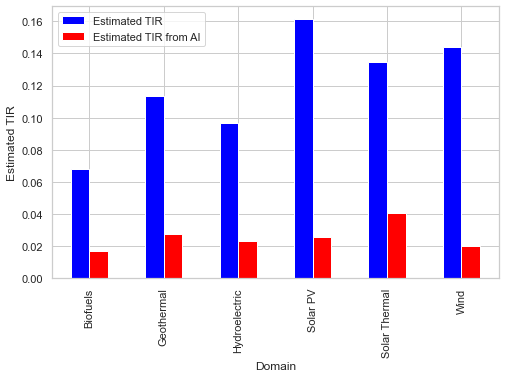

In [76]:
fig=figure(figsize=(figw, 5))
ax=subplot(1,1,1)
plt.ylabel('Estimated TIR')
#ax.get_legend().remove()
dddf=DF_estimated_K_NEW_DOMAINS[['Domain','predicted_K_HSR_CPC', 'predicted_K_fromAI']]
ddf=dddf.rename(columns={'predicted_K_HSR_CPC': 'Estimated TIR', 'predicted_K_fromAI': 'Estimated TIR from AI'}, inplace=True)
dddf.plot.bar(x='Domain',  ax=ax, color=['blue','red']) #, legend=None
#DF_estimated_K_NEW_DOMAINS[DF_estimated_K_NEW_DOMAINS['Domain'].isin(Techniques) ][['Domain','predicted_K_HSR_WIPO']].plot.bar(x='Domain', alpha=0.5, ax=ax, color='yellow')
#L=legend()
legend(loc='upper left')
name_fig = 'LCET_TIR_Katz'
format_fig = '.tiff'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)


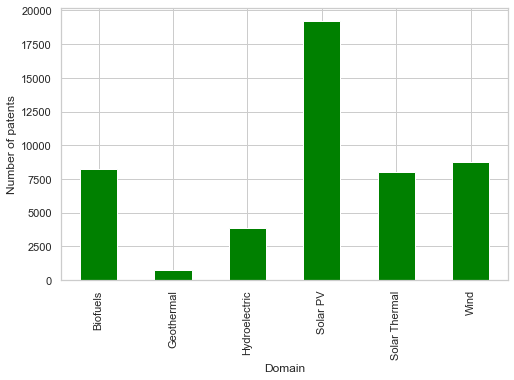

In [77]:
fig=figure(figsize=(figw, 5))
ax2=subplot(1,1,1)
plt.ylabel('Number of patents')
DF_estimated_K_NEW_DOMAINS[['Domain','patents_CPC']].plot.bar(x='Domain', ax=ax2, color='green')

ax2.get_legend().remove()



# Export
name_fig = 'NUMBERS_AI_Techniques_CPConly'
format_fig = '.tiff'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)


In [78]:
DF_estimated_K_NEW_DOMAINS[DF_estimated_K_NEW_DOMAINS.Domain=='Solar PV']['patents_CPC']

3    19198
Name: patents_CPC, dtype: int64

In [79]:
list(DF_estimated_K_NEW_DOMAINS_HSR.Domain.values)

['Biofuels',
 'Geothermal',
 'Hydroelectric',
 'Solar PV',
 'Solar Thermal',
 'Wind']

# Estimated densities of predicted improvement rates

In [80]:
DF_estimated_K_NEW_DOMAINS_HSR[DF_estimated_K_NEW_DOMAINS_HSR.Domain=='Solar PV']


,Domain,predicted_log_K_HSR_CPC,predicted_K_HSR_CPC,predicted_log_K_HSR_fromAI,predicted_K_HSR_fromAI,Katz_centrality_60_RPbyYear,AI_centrality_RPbyYear,pred_std_HSR_CPC,pred_std_HSR_withoutAI
pv,Solar PV,-2.075863,0.161331,-3.978862,0.027086,0.481198,0.162178,0.709316,0.860376


Biofuels
Geothermal
Hydroelectric


C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff

Solar PV
Solar Thermal
Wind


C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)
C:\Users\test\AppData\Local\Temp/ipykernel_14412/4255336620.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_likelihood_diff = DF_likelihood_diff.append(DF)


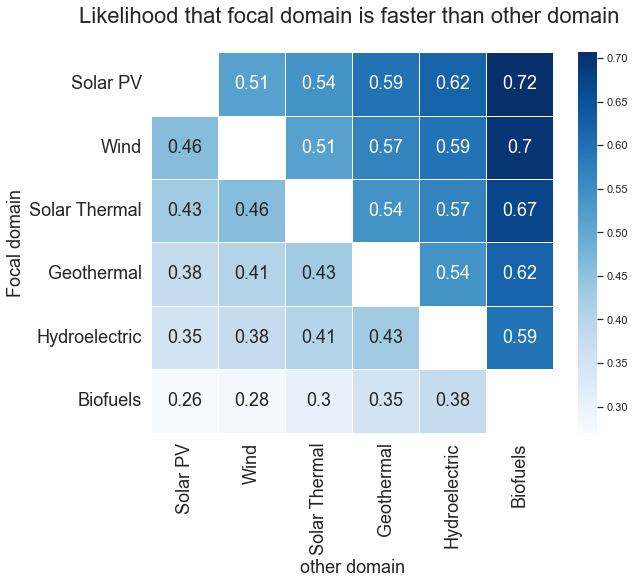

In [81]:
from scipy.stats import norm

from scipy import stats
from scipy.stats import norm

category=list(DF_estimated_K_NEW_DOMAINS.Domain.values)
rcategory=[]

# See answers here to understand how prob that A>B is computed:
# https://stats.stackexchange.com/questions/26886/why-is-the-variance-of-x-y-equal-to-the-sum-of-the-variances-when-x-y-are-in/31328#31328
# https://stats.stackexchange.com/questions/50501/probability-of-one-random-variable-being-greater-than-another
DF_likelihood_diff = pd.DataFrame()
for focal_domain in category:
     
     print(focal_domain)
     if DF_estimated_K_NEW_DOMAINS[DF_estimated_K_NEW_DOMAINS.Domain==focal_domain]['patents_CPC'].values[0]==0:
        print('cant find',  focal_domain)
        continue
    
        
     rcategory.append(focal_domain) 
     mu_focal = array(DF_estimated_K_NEW_DOMAINS_HSR['predicted_log_K_HSR_CPC'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==focal_domain])
     sigma_focal = array(DF_estimated_K_NEW_DOMAINS_HSR['pred_std_HSR_CPC'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==focal_domain])
     for other_domain in list(set(category).difference([focal_domain])):
        #print(other_domain)
        if DF_estimated_K_NEW_DOMAINS[DF_estimated_K_NEW_DOMAINS.Domain==other_domain]['patents_CPC'].values[0]==0:
            print('cant find', domain)
            continue

        
        mu_other = array(DF_estimated_K_NEW_DOMAINS_HSR['predicted_log_K_HSR_CPC'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==other_domain])
        sigma_other = array(DF_estimated_K_NEW_DOMAINS_HSR['pred_std_HSR_CPC'][DF_estimated_K_NEW_DOMAINS_HSR['Domain']==other_domain])
        mu_diff = mu_focal - mu_other
        sigma_diff = sigma_focal + sigma_other
        #print(sigma_diff)
        x = np.linspace(mu_diff-3.4*sigma_diff,mu_diff+3.4*sigma_diff, 100) #np.linspace(norm.ppf(0.0001),norm.ppf(0.9999), 100)
        y = norm.cdf(x, mu_diff, sigma_diff)
        cdf_zero = 1-(y[x >= 0][0])
        DF = (pd.DataFrame({'focal_domain':focal_domain,
                          'other_domain':other_domain,
                           'likelihood_focal_greater_other':cdf_zero},index=[focal_domain]))
        DF_likelihood_diff = DF_likelihood_diff.append(DF)

DF_likelihood_diff = DF_likelihood_diff[DF_likelihood_diff['focal_domain']!=DF_likelihood_diff['other_domain']]

# create pivot table
DF_pivot = DF_likelihood_diff.pivot('focal_domain', 'other_domain', 'likelihood_focal_greater_other')

# sort DF_pivot columns by predicted k of domains
sorted_columns = (array(DF_estimated_K_NEW_DOMAINS_HSR[['Domain','predicted_K_HSR_CPC']]
                        [DF_estimated_K_NEW_DOMAINS_HSR.Domain.isin(rcategory)]
                        .sort_values('predicted_K_HSR_CPC',ascending=False)['Domain']))
DF_pivot = DF_pivot[sorted_columns]

# sort DF_pivot rows by predicted k of domains
ix = list(range(len(sorted_columns)))
new_index = pd.DataFrame({'domain':sorted_columns,'ix':ix},index=[ix])
DF_pivot=(pd.merge(DF_pivot, new_index,
                                 how = 'outer', left_on = array(DF_pivot.index), 
                                 right_on = ['domain']))
DF_pivot.sort_values('ix',ascending=True,inplace=True)
del DF_pivot['ix']
DF_pivot.rename(columns={"domain":"focal_domain"},inplace=True)
DF_pivot.set_index('focal_domain',inplace=True)


f, ax = subplots(figsize=(9, 7))

ax = sns.heatmap(DF_pivot, robust=True, annot=True, linewidths=.5, annot_kws={"size": 18}, cmap='Blues') #vmin=0, vmax=5
yticks(rotation=0,fontsize=18)
xticks(rotation=90,fontsize=18)
ylabel('Focal domain',fontsize=18)
xlabel('other domain',fontsize=18)
ax.set_title('Likelihood that focal domain is faster than other domain \n ',fontsize=22)

# Export
name_fig = 'likelihood_domain_faster_than_other_domain_Techs_CPConly'
format_fig = '.pdf'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=150)
format_fig = '.tiff'
savefig(export_path+name_fig+format_fig, bbox_inches='tight', dpi=400)